## Activation Visual Verification

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import nitty_gitty.nn.functional as F
from nitty_gitty import Tensor

def plot_activation_and_grad(activation_fn, name, xmin=-5, xmax=5, step=0.1):
    x = np.arange(xmin, xmax, step)

    x_tensor = np.array(x[np.newaxis, ...], dtype=np.float32)

    x_tensor = Tensor(x_tensor, requires_grad=True)
    y = activation_fn(x_tensor)
    y.sum().backward()
    grad_y = x_tensor.grad
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, y.data[0], label='Forward')
    plt.plot(x, grad_y[0], label='Gradient', linestyle='--')
    plt.title(f"{name} Activation and Gradient")
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:
def plot_grad_scale(grad, name):    
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(grad.shape[0]), grad, label='Forward')

    plt.title(f"{name} grad scale")
    plt.legend()
    plt.grid(True)
    plt.show()

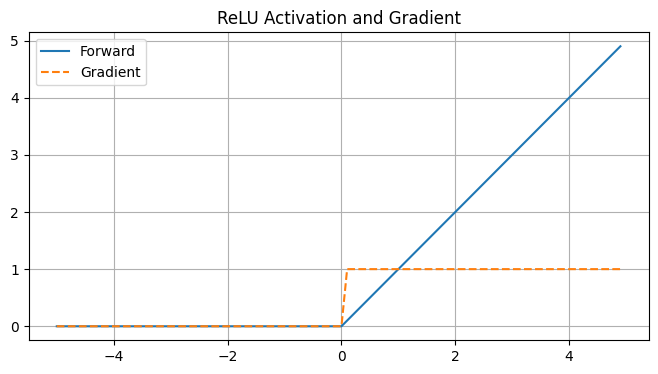

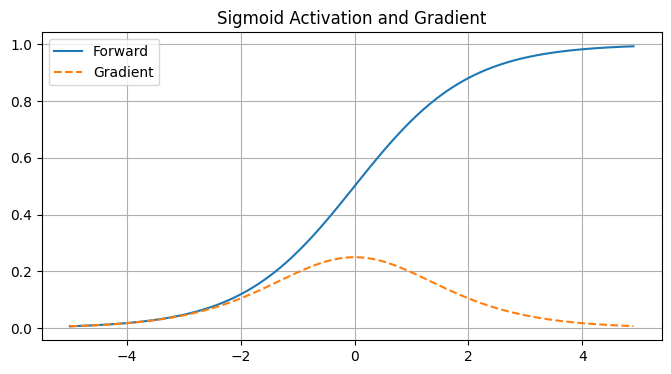

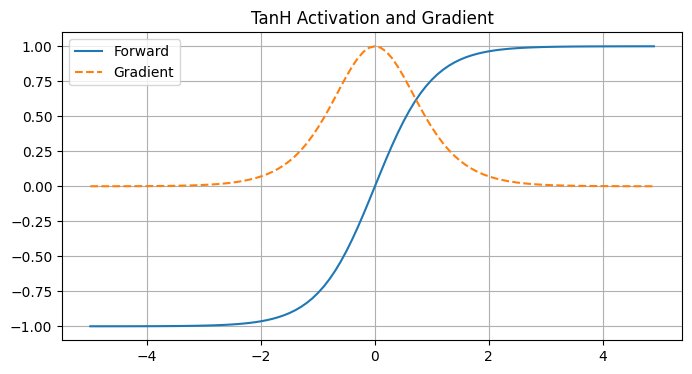

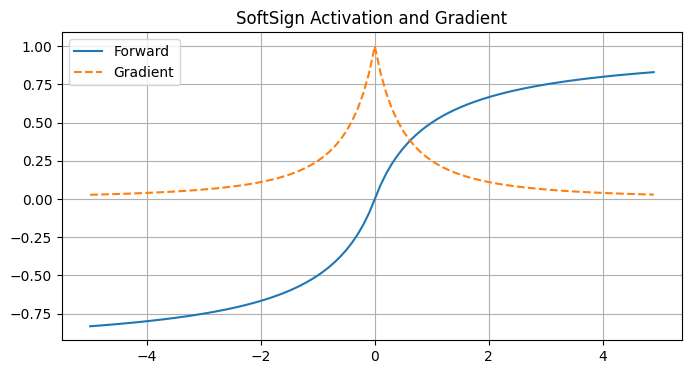

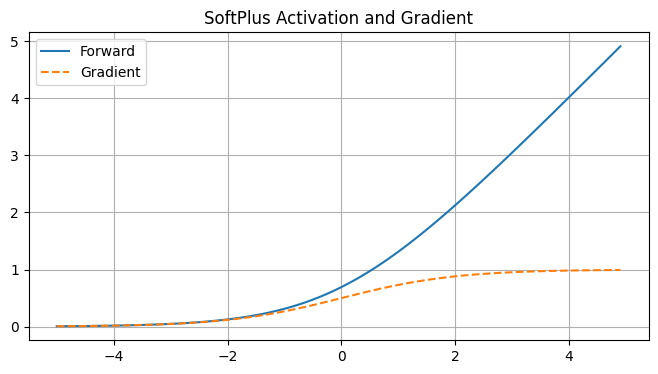

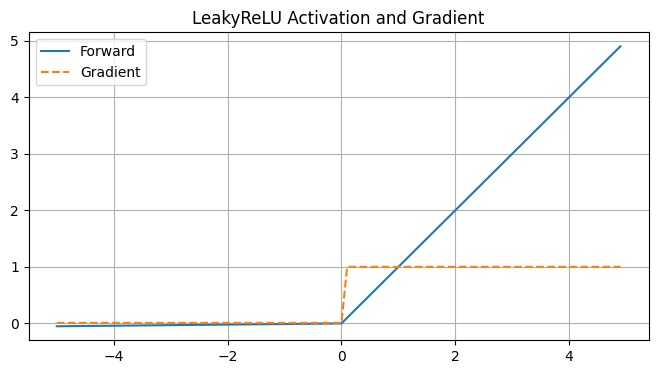

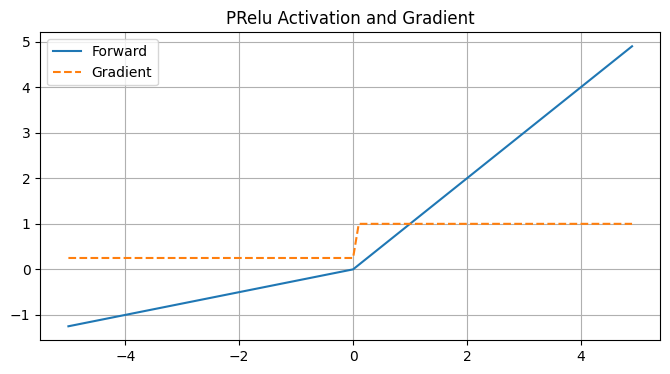

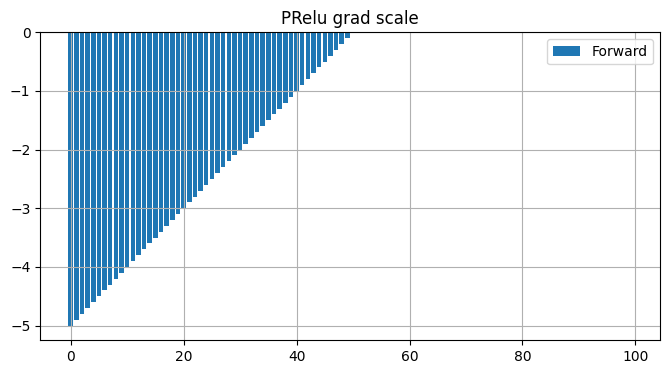

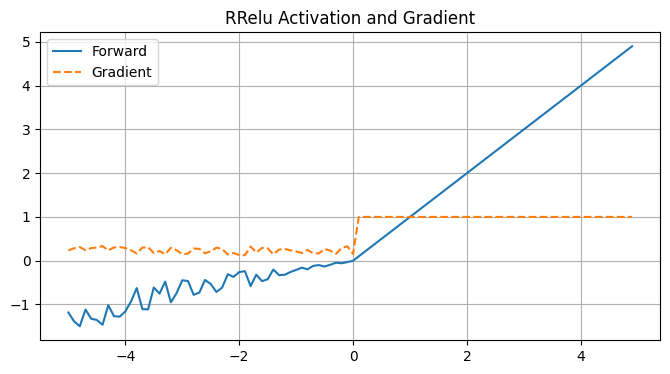

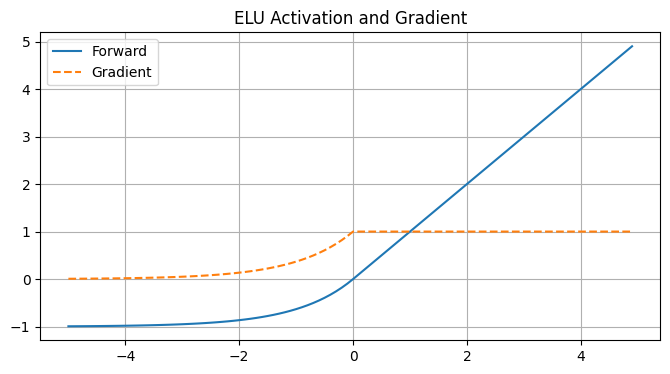

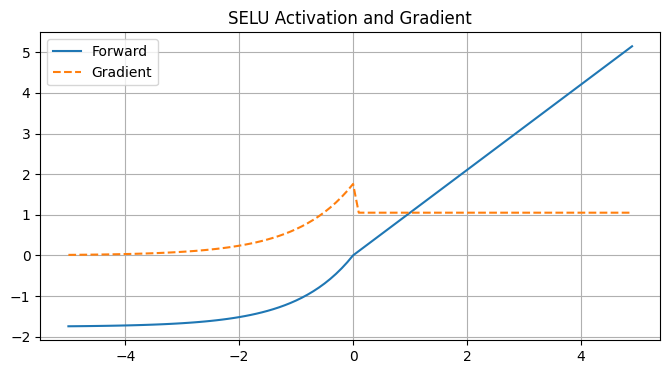

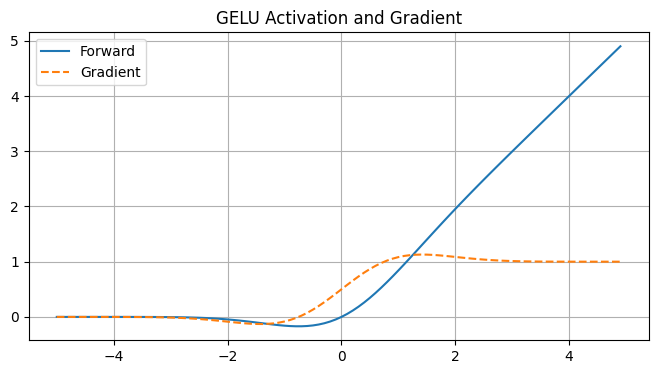

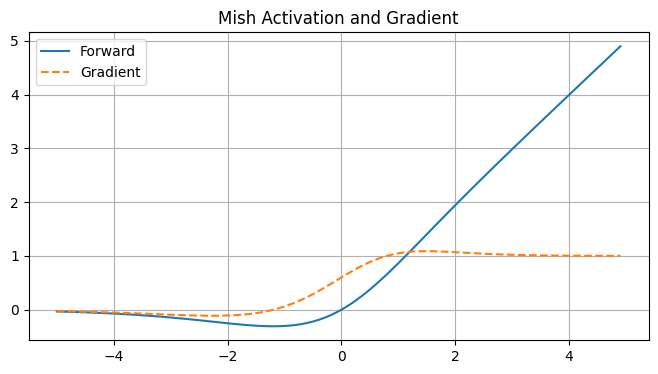

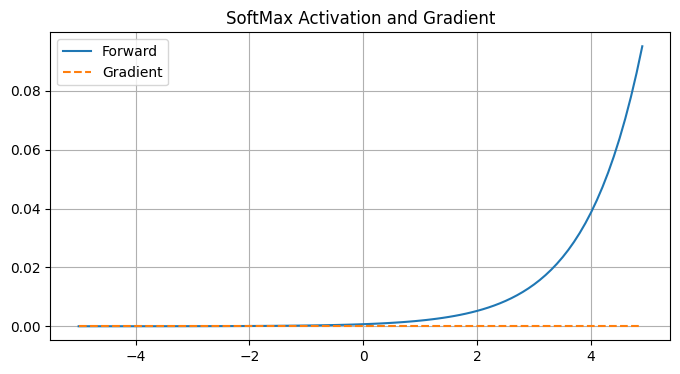

In [5]:
plot_activation_and_grad(F.ReLU(), name="ReLU")
plot_activation_and_grad(F.Sigmoid(), name="Sigmoid")
plot_activation_and_grad(F.TanH(), name="TanH")
plot_activation_and_grad(F.SoftSign(), name="SoftSign")
plot_activation_and_grad(F.SoftPlus(), name="SoftPlus")
plot_activation_and_grad(F.LeakyReLU(), name="LeakyReLU")

prelu = F.PReLU(num_parameters=100)
plot_activation_and_grad(prelu, name="PRelu")
plot_grad_scale(prelu.weight.grad, name="PRelu")

plot_activation_and_grad(F.RReLU(), name="RRelu")
plot_activation_and_grad(F.Elu(), name="ELU")
plot_activation_and_grad(F.SeLU(), name="SELU")
plot_activation_and_grad(F.GeLU(), name="GELU")
plot_activation_and_grad(F.Mish(), name="Mish")
plot_activation_and_grad(F.SoftMax(), name="SoftMax")

###  Pytorch Vs Nitty-Gitty

In [6]:
import torch
import numpy as np
import random


def compare_with_torch(custom_fn, torch_fn, name, tol=1e-5, seed=0, sync_weights=False):
    print(f"\n--- Testing {name} ---")
    # --- Set deterministic seeds ---
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    # Try to enable deterministic algorithms where available
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        # fall back to legacy flags if needed
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # --- Optional: synchronize parameter initializations ---
    if sync_weights and hasattr(custom_fn, 'weight') and hasattr(torch_fn, 'weight'):
        try:
            w_shape = tuple(torch_fn.weight.shape)
            weight_np = np.random.randn(*w_shape).astype(np.float32)
            # assign to torch module
            try:
                torch_fn.weight.data.copy_(torch.from_numpy(weight_np))
            except Exception:
                # if copy_ fails, try direct assign
                torch_fn.weight = torch.nn.Parameter(torch.from_numpy(weight_np))
            # assign to custom module (best-effort)
            try:
                # if custom weight uses a `.data` attribute
                if hasattr(custom_fn.weight, 'data'):
                    custom_fn.weight.data = weight_np
                else:
                    # try wrapping as nitty_gitty Tensor
                    custom_fn.weight = Tensor(weight_np, requires_grad=True)
            except Exception:
                print("Warning: failed to sync custom_fn.weight; continuing with each init.")
        except Exception as e:
            print("Warning: failed to generate/sync weights:", e)


    # Create test input
    x_np = np.linspace(-5, 5, 10).astype(np.float32)
    x_torch = torch.tensor(x_np, requires_grad=True)

    # --- Torch forward ---
    y_torch = torch_fn(x_torch)
    y_torch.sum().backward()
    torch_forward = y_torch.detach().numpy()
    torch_grad = x_torch.grad.detach().numpy()

    # --- Custom forward ---
    x_tensor = Tensor(x_np, requires_grad=True)
    y_tensor = custom_fn(x_tensor)
    y_tensor.sum().backward()
    y_custom = y_tensor.data
    grad_custom = x_tensor.grad

    # --- Compare ---
    forward_close = np.allclose(y_custom, torch_forward, atol=tol)
    backward_close = np.allclose(grad_custom, torch_grad, atol=tol)

    print("Forward close:", forward_close)
    print("Backward close:", backward_close)
    print("Torch Forward:", torch_forward)
    print("Custom Forward:", y_custom)
    print("Torch Grad:", torch_grad)
    print("Custom Grad:", grad_custom)


In [7]:
compare_with_torch(F.ReLU(), torch.nn.modules.activation.ReLU(), "ReLU")


compare_with_torch(F.ReLU(), torch.nn.modules.activation.ReLU(), name="ReLU")
compare_with_torch(F.Sigmoid(), torch.nn.modules.activation.Sigmoid(), name="Sigmoid")
compare_with_torch(F.TanH(), torch.nn.modules.activation.Tanh(), name="TanH")
compare_with_torch(F.SoftSign(), torch.nn.modules.activation.Softsign(), name="SoftSign")
compare_with_torch(F.SoftPlus(), torch.nn.modules.activation.Softplus(), name="SoftPlus")
compare_with_torch(F.LeakyReLU(), torch.nn.modules.activation.LeakyReLU(), name="LeakyReLU")

prelu = F.PReLU(num_parameters=1)
compare_with_torch(prelu, torch.nn.modules.activation.PReLU(num_parameters=1), name="PRelu")

compare_with_torch(F.RReLU(), torch.nn.modules.activation.RReLU(), name="RRelu")
compare_with_torch(F.Elu(), torch.nn.modules.activation.ELU(), name="ELU")
compare_with_torch(F.SeLU(), torch.nn.modules.activation.SELU(), name="SELU")
compare_with_torch(F.GeLU(), torch.nn.modules.activation.GELU(approximate="tanh"), name="GELU")
compare_with_torch(F.Mish(), torch.nn.modules.activation.Mish(), name="Mish")
compare_with_torch(F.SoftMax(), torch.nn.modules.activation.Softmax(), name="SoftMax")


--- Testing ReLU ---
Forward close: True
Backward close: True
Torch Forward: [0.        0.        0.        0.        0.        0.5555556 1.6666666
 2.7777777 3.8888888 5.       ]
Custom Forward: [-0.        -0.        -0.        -0.        -0.         0.5555556
  1.6666666  2.7777777  3.8888888  5.       ]
Torch Grad: [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
Custom Grad: [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]

--- Testing ReLU ---
Forward close: True
Backward close: True
Torch Forward: [0.        0.        0.        0.        0.        0.5555556 1.6666666
 2.7777777 3.8888888 5.       ]
Custom Forward: [-0.        -0.        -0.        -0.        -0.         0.5555556
  1.6666666  2.7777777  3.8888888  5.       ]
Torch Grad: [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
Custom Grad: [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]

--- Testing Sigmoid ---
Forward close: True
Backward close: True
Torch Forward: [0.00669285 0.02005754 0.05853691 0.1588691  0.36457646 0.6354236
 0.84113085 0.94146305 0.97994244 0.9933072 ]
Custom Fo

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
